# Amazon Reviews Sentiment Analysis - Exploratory Data Analysis

This notebook explores the Amazon Reviews Polarity Dataset to understand its characteristics and prepare for sentiment analysis modeling.

In [3]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Configure matplotlib
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Initial Exploration

First, let's load our dataset. We'll be working with a subset of the Amazon Reviews Polarity Dataset that we've already prepared.

In [4]:
# Get project directory path
# we need to go up one level from the notebook directory
notebook_dir = os.path.abspath('')
project_dir = os.path.dirname(notebook_dir)

# add project directory to sys.path so we can import our modules
if project_dir not in sys.path:
    sys.path.append(project_dir)

# set data paths
data_dir = os.path.join(project_dir, 'data')
processed_data_dir = os.path.join(data_dir, 'processed')

# load data if it exists
data_path = os.path.join(processed_data_dir, 'amazon_reviews_subset.csv')

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset loaded with {df.shape[0]} reviews and {df.shape[1]} columns.")
else:
    print("Dataset not found. Please run the data_acquisition.py script first.")
    # For demonstration purposes, we'll create a small sample dataset
    df = pd.DataFrame({
        'sentiment': [1, 0, 1, 0, 1],
        'title': ['Great product', 'Terrible', 'Love it', 'Waste of money', 'Awesome'],
        'review': [
            'This is a fantastic product that exceeded my expectations.',
            'The quality is poor and it broke after two uses.',
            'I love this product and use it every day!',
            'Complete waste of money. Don\'t buy this.',
            'Awesome product, great value for money!'
        ]
    })

Dataset loaded with 1000 reviews and 3 columns.


In [5]:
# Examine the first few rows
df.head()

,sentiment,title,review
0,0,Corel does not patch or stand by this product.,I loved this program. Used it for years. Now p...
1,0,Poor vocals and song selection,"There are a few highlights on Tu, Th, and Sat...."
2,0,WORST Shower Head out there!! LEAKS!!,This shower head is cheap PLASTIC!! Completely...
3,0,"Amazing, but hopeless",I thought this was a horrible book.It is beaut...
4,1,THE BEST ALBUM OF '99,I cannot get this CD out of my player! Soulful...


In [6]:
# Check basic statistics and information
print("Dataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)
print("\nSummary statistics:")
df.describe(include='all')

Dataset shape: (1000, 3)

Column data types:
sentiment     int64
title        object
review       object
dtype: object

Summary statistics:


,sentiment,title,review
count,1000.00000,1000,1000
unique,NaN,990,1000
top,NaN,Disappointing,I loved this program. Used it for years. Now p...
freq,NaN,4,1
mean,0.50000,NaN,NaN
std,0.50025,NaN,NaN
min,0.00000,NaN,NaN
25%,0.00000,NaN,NaN
50%,0.50000,NaN,NaN
75%,1.00000,NaN,NaN


In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
missing_values

# Note to self: The NaNs in the above summary stats don't count toward this, theyre just placeholders for stat measures that don't apply to these datatypes

Missing values per column:


sentiment    0
title        0
review       0
dtype: int64

Sentiment distribution:
0    500
1    500
Name: sentiment, dtype: int64


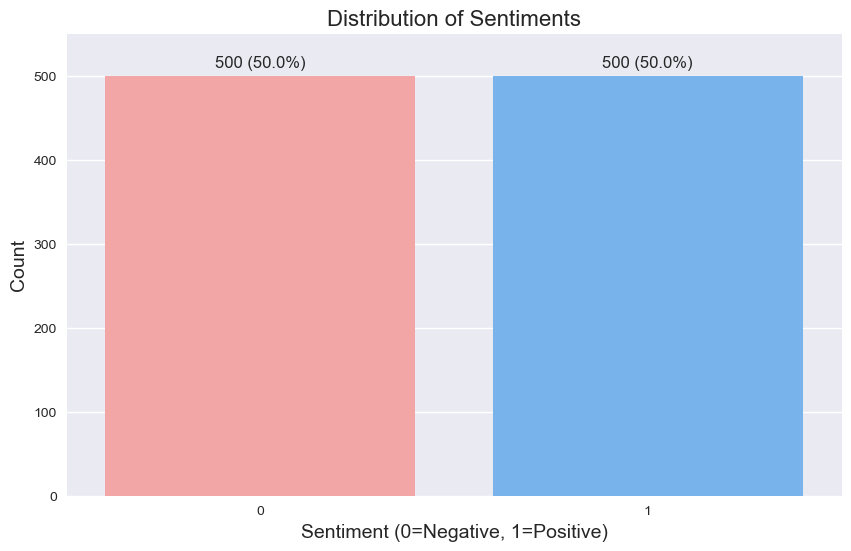

In [11]:
# Check the distribution of sentiments
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment distribution:")
print(sentiment_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=df, palette=['#ff9999', '#66b3ff'])
plt.title('Distribution of Sentiments', fontsize=16)
plt.xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add count labels on top of bars
for i, count in enumerate(sentiment_counts):
    ax.text(i, count + 10, f"{count} ({count/len(df):.1%})", ha='center', fontsize=12)

plt.ylim(0, max(sentiment_counts) * 1.1)  # Add some space for the labels
plt.show()

## 2. Text Exploration and Analysis

Now, let's explore the characteristics of the review text data.

In [12]:
# Calculate text length statistics
df['title_length'] = df['title'].str.len()
df['review_length'] = df['review'].str.len()
df['title_word_count'] = df['title'].str.split().str.len()
df['review_word_count'] = df['review'].str.split().str.len()

# Display summary statistics
text_stats = df[['title_length', 'review_length', 'title_word_count', 'review_word_count']].describe()
text_stats

,title_length,review_length,title_word_count,review_word_count
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,25.125000,410.052000,4.467000,74.792000
std,13.817174,236.669123,2.653668,42.886805
min,1.000000,77.000000,1.000000,13.000000
25%,15.000000,207.000000,2.000000,38.000000
50%,22.000000,362.000000,4.000000,66.000000
75%,33.000000,586.250000,6.000000,105.250000
max,124.000000,979.000000,22.000000,194.000000


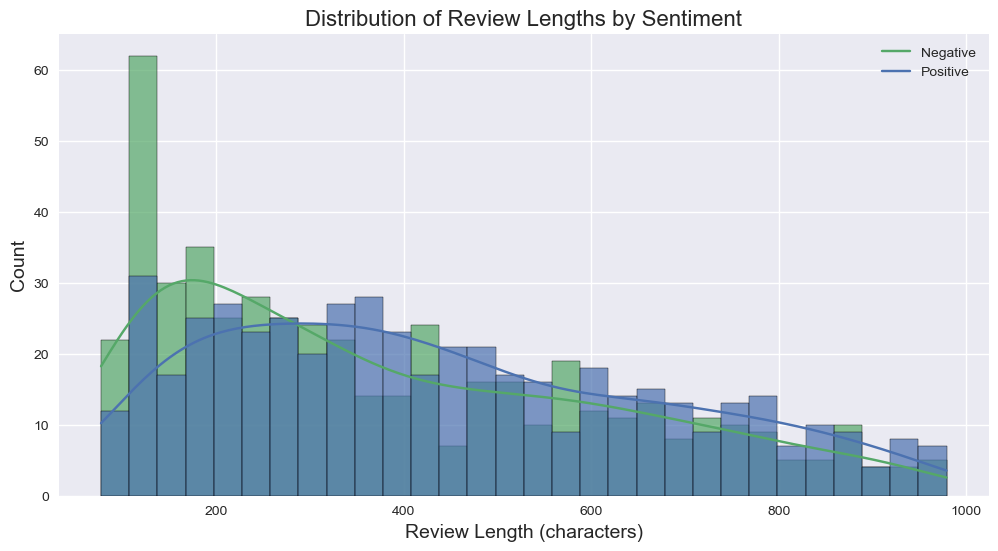

In [13]:
# Visualize review length distribution by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length', hue='sentiment', bins=30, alpha=0.7, kde=True)
plt.title('Distribution of Review Lengths by Sentiment', fontsize=16)
plt.xlabel('Review Length (characters)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['Negative', 'Positive'])
plt.show()

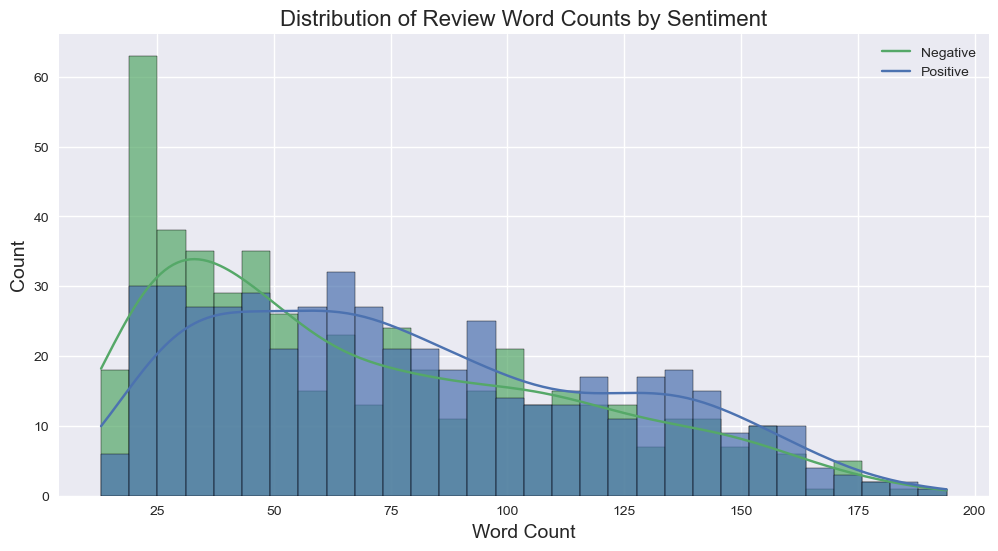

In [14]:
# Visualize word count distribution by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_word_count', hue='sentiment', bins=30, alpha=0.7, kde=True)
plt.title('Distribution of Review Word Counts by Sentiment', fontsize=16)
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['Negative', 'Positive'])
plt.show()

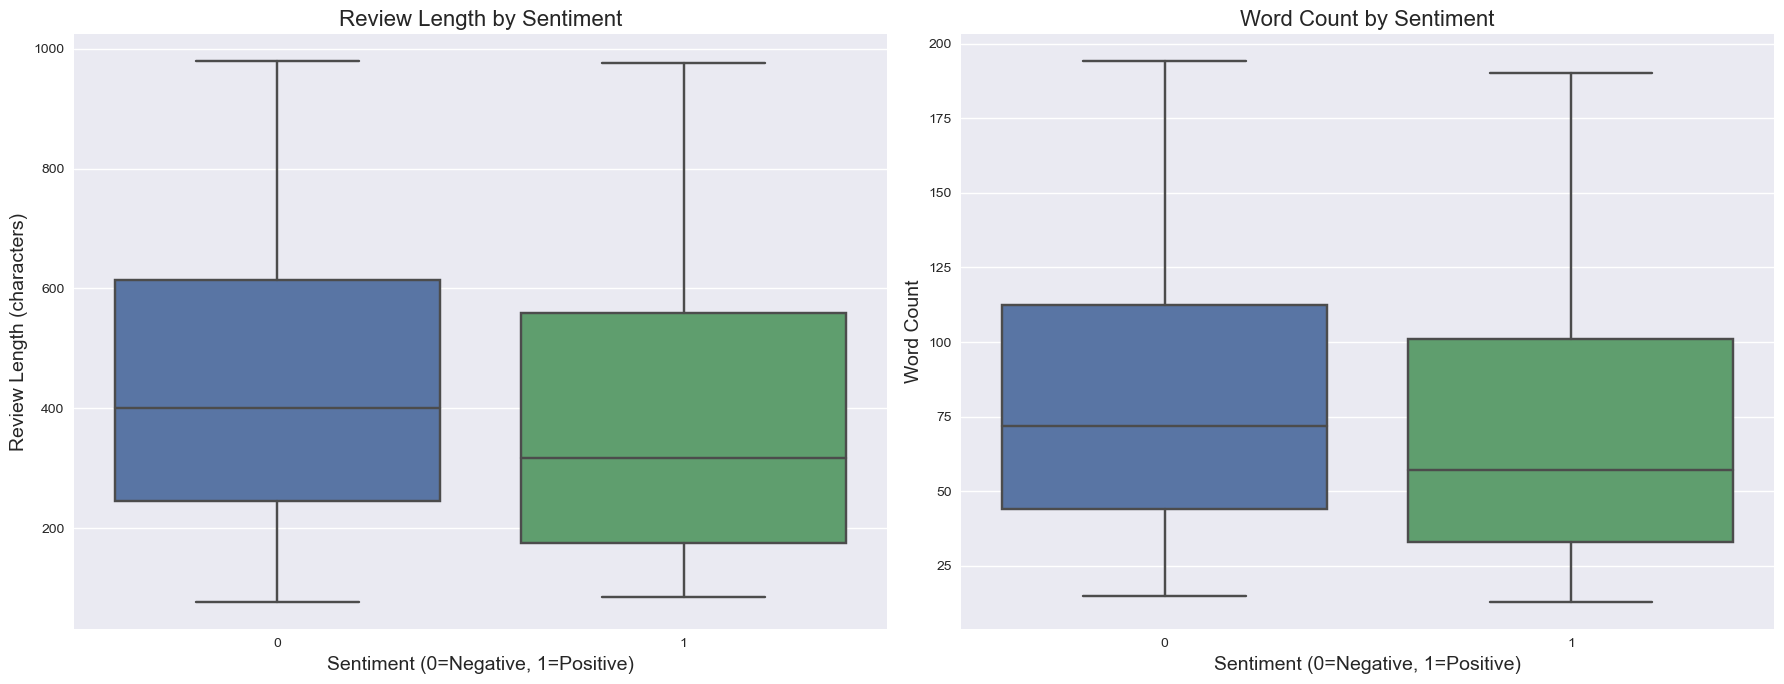

In [15]:
# Let's see if there's a difference in text length between positive and negative reviews
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Box plot for review length
sns.boxplot(x='sentiment', y='review_length', data=df, ax=axes[0])
axes[0].set_title('Review Length by Sentiment', fontsize=16)
axes[0].set_xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=14)
axes[0].set_ylabel('Review Length (characters)', fontsize=14)

# Box plot for word count
sns.boxplot(x='sentiment', y='review_word_count', data=df, ax=axes[1])
axes[1].set_title('Word Count by Sentiment', fontsize=16)
axes[1].set_xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=14)
axes[1].set_ylabel('Word Count', fontsize=14)

plt.tight_layout()
plt.show()

## 3. Common Words Analysis

Let's analyze the most common words in positive and negative reviews separately.

In [18]:
# Download NLTK resources if needed
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')  # Also check for punkt_tab
except LookupError:
    print("Downloading NLTK resources...")
    nltk.download('stopwords')
    nltk.download('punkt')
    # The error message mentions punkt_tab, which is what we need to download
    nltk.download('punkt_tab', quiet=True)

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Function to get most common words
def get_common_words(texts, n=20, remove_stopwords=True):
    """Extract most common words from a series of texts."""
    words = []
    for text in texts:
        # Convert to lowercase and tokenize
        tokens = word_tokenize(text.lower())
        
        # Remove punctuation and non-alphabetic tokens
        tokens = [word for word in tokens if word.isalpha()]
        
        # Remove stopwords if requested
        if remove_stopwords:
            tokens = [word for word in tokens if word not in stop_words]
            
        words.extend(tokens)
    
    # Count words and return top N
    word_counts = Counter(words)
    return word_counts.most_common(n)

# Get common words for positive and negative reviews
positive_reviews = df[df['sentiment'] == 1]['review']
negative_reviews = df[df['sentiment'] == 0]['review']

# Get top 20 words for each sentiment
positive_words = get_common_words(positive_reviews, n=20)
negative_words = get_common_words(negative_reviews, n=20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ripst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ripst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


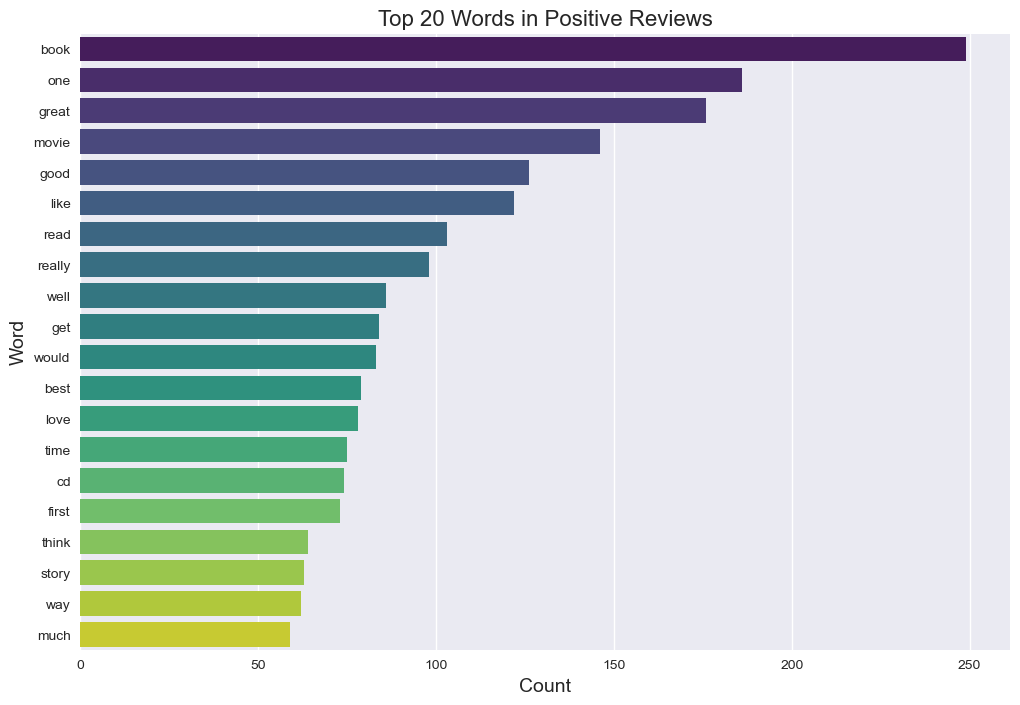

In [19]:
# Plot the most common words in positive reviews
plt.figure(figsize=(12, 8))
pos_df = pd.DataFrame(positive_words, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=pos_df, palette='viridis')
plt.title('Top 20 Words in Positive Reviews', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.show()

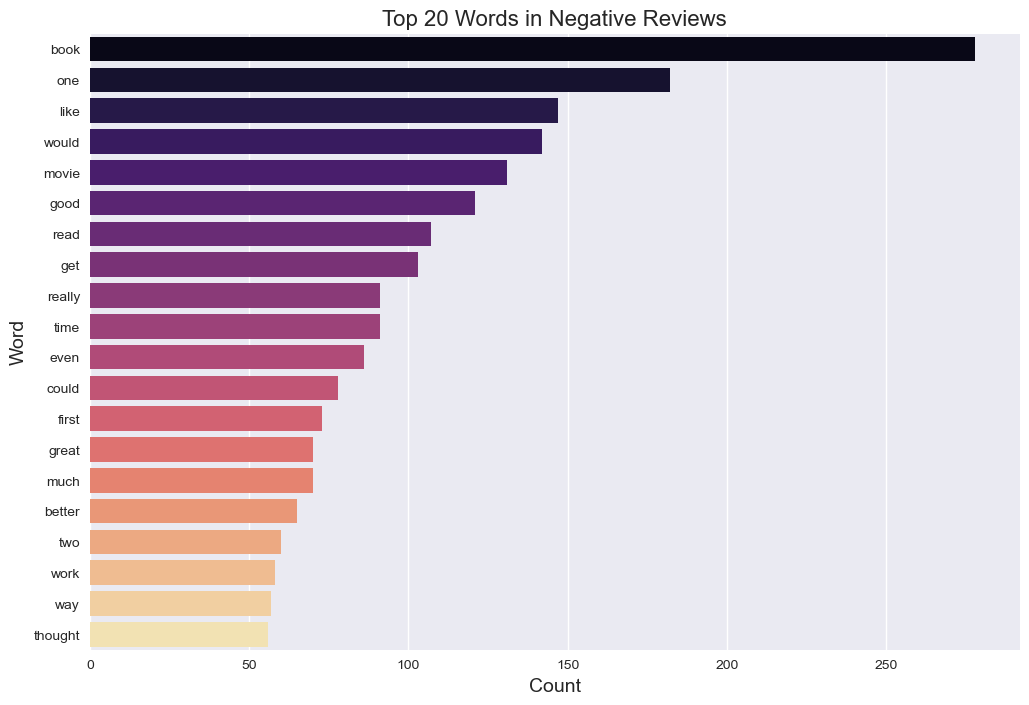

In [20]:
# Plot the most common words in negative reviews
plt.figure(figsize=(12, 8))
neg_df = pd.DataFrame(negative_words, columns=['word', 'count'])
sns.barplot(x='count', y='word', data=neg_df, palette='magma')
plt.title('Top 20 Words in Negative Reviews', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Word', fontsize=14)
plt.show()

## 4. Word Clouds

Let's create word clouds to visualize the most common words in positive and negative reviews.

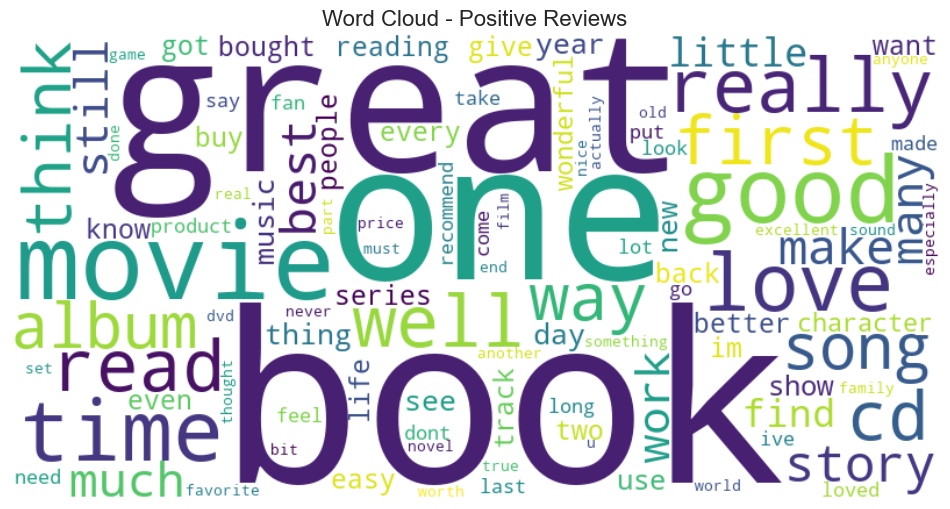

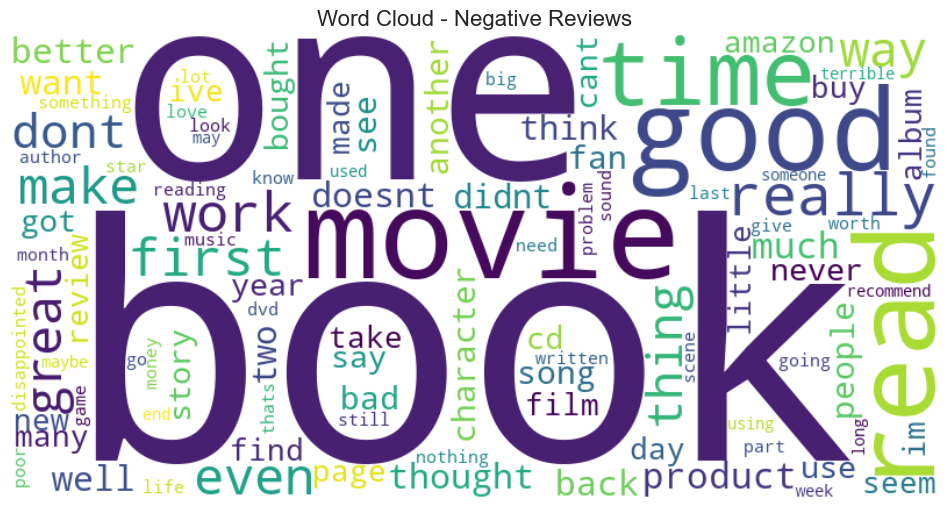

In [21]:
# Generate word clouds for positive and negative reviews
def generate_wordcloud(text_series, title):
    """Generate a word cloud from a series of texts."""
    # Combine all texts
    text = ' '.join(text_series)
    
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())
    
    # Remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, contour_width=3, contour_color='steelblue',
                          colormap='viridis', random_state=42).generate(text)
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate word clouds
generate_wordcloud(positive_reviews, 'Word Cloud - Positive Reviews')
generate_wordcloud(negative_reviews, 'Word Cloud - Negative Reviews')

## 5. N-grams Analysis

Let's look at the most common bigrams (2-word phrases) in the reviews, which might provide more context than individual words.

In [22]:
# Function to get most common n-grams
def get_ngrams(texts, n=2, top_n=20):
    """Extract most common n-grams from a series of texts."""
    all_ngrams = []
    
    for text in texts:
        # Convert to lowercase and tokenize
        tokens = word_tokenize(text.lower())
        
        # Remove punctuation and non-alphabetic tokens
        tokens = [word for word in tokens if word.isalpha()]
        
        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        
        # Generate n-grams
        ngrams = [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        all_ngrams.extend(ngrams)
    
    # Count n-grams and return top N
    ngram_counts = Counter(all_ngrams)
    return ngram_counts.most_common(top_n)

# Get top bigrams for positive and negative reviews
positive_bigrams = get_ngrams(positive_reviews, n=2, top_n=15)
negative_bigrams = get_ngrams(negative_reviews, n=2, top_n=15)

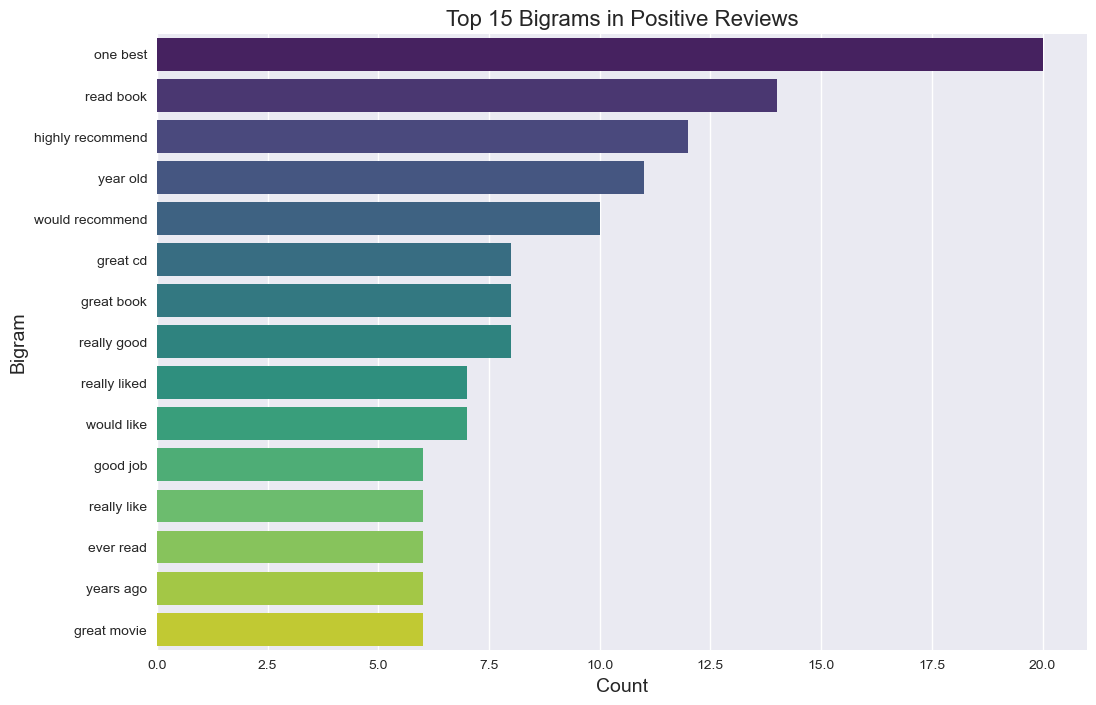

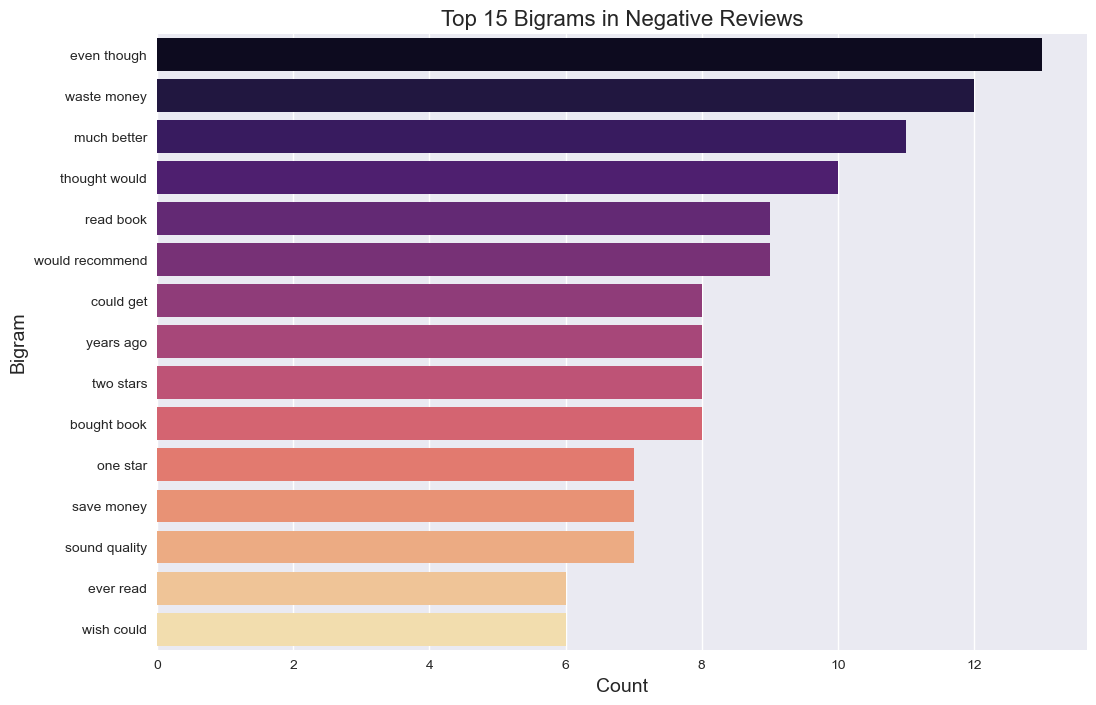

In [23]:
# Plot bigrams for positive reviews
plt.figure(figsize=(12, 8))
pos_bigram_df = pd.DataFrame(positive_bigrams, columns=['bigram', 'count'])
sns.barplot(x='count', y='bigram', data=pos_bigram_df, palette='viridis')
plt.title('Top 15 Bigrams in Positive Reviews', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Bigram', fontsize=14)
plt.show()

# Plot bigrams for negative reviews
plt.figure(figsize=(12, 8))
neg_bigram_df = pd.DataFrame(negative_bigrams, columns=['bigram', 'count'])
sns.barplot(x='count', y='bigram', data=neg_bigram_df, palette='magma')
plt.title('Top 15 Bigrams in Negative Reviews', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Bigram', fontsize=14)
plt.show()

## 6. Sentiment Indicators

Let's check some potential indicators of sentiment that we can use as features.

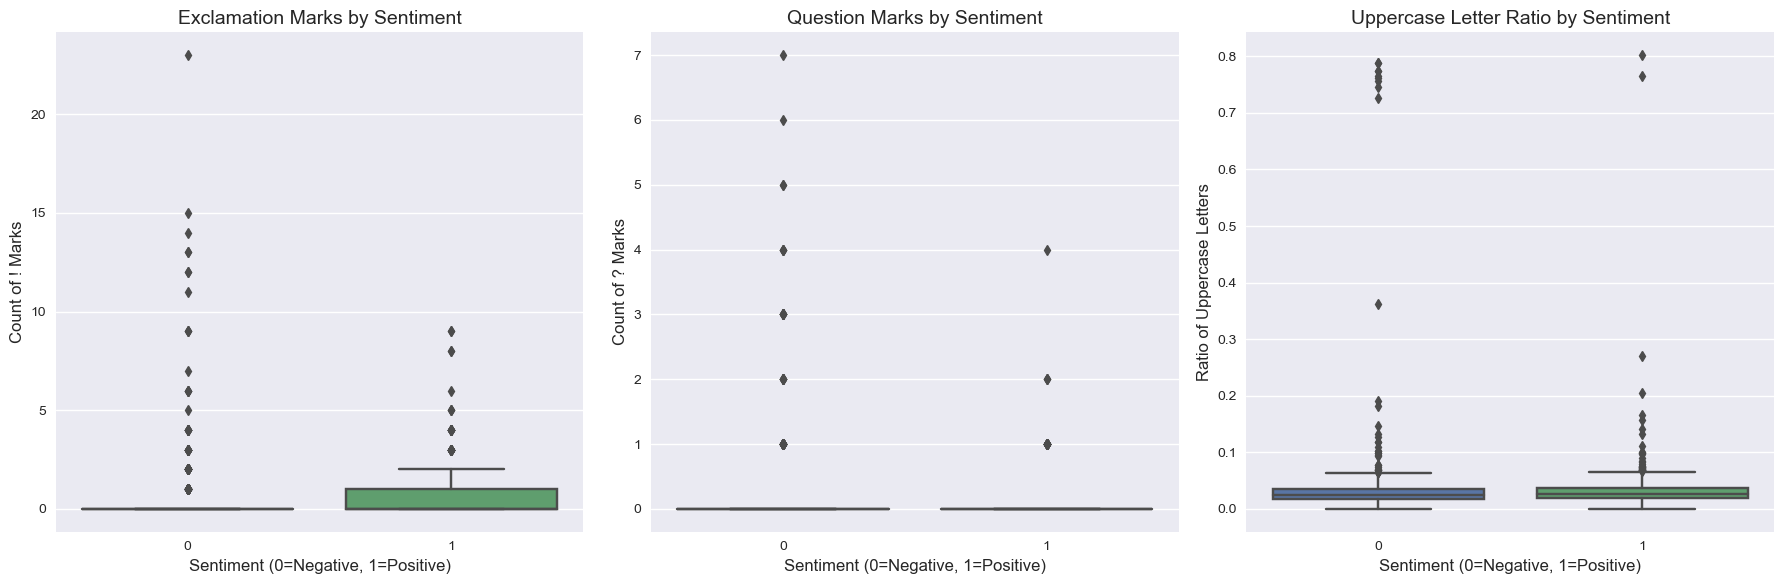

In [24]:
# Calculate additional text features
df['exclamation_count'] = df['review'].str.count('!')
df['question_count'] = df['review'].str.count('\?')
df['uppercase_ratio'] = df['review'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)

# Visualize these features by sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Exclamation marks
sns.boxplot(x='sentiment', y='exclamation_count', data=df, ax=axes[0])
axes[0].set_title('Exclamation Marks by Sentiment', fontsize=14)
axes[0].set_xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
axes[0].set_ylabel('Count of ! Marks', fontsize=12)

# Question marks
sns.boxplot(x='sentiment', y='question_count', data=df, ax=axes[1])
axes[1].set_title('Question Marks by Sentiment', fontsize=14)
axes[1].set_xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
axes[1].set_ylabel('Count of ? Marks', fontsize=12)

# Uppercase ratio
sns.boxplot(x='sentiment', y='uppercase_ratio', data=df, ax=axes[2])
axes[2].set_title('Uppercase Letter Ratio by Sentiment', fontsize=14)
axes[2].set_xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
axes[2].set_ylabel('Ratio of Uppercase Letters', fontsize=12)

plt.tight_layout()
plt.show()

## 7. Text Title Analysis

Let's examine the relationship between the title and the review text.

Correlation between title length and review length:
               title_length  review_length
title_length        1.00000        0.20474
review_length       0.20474        1.00000


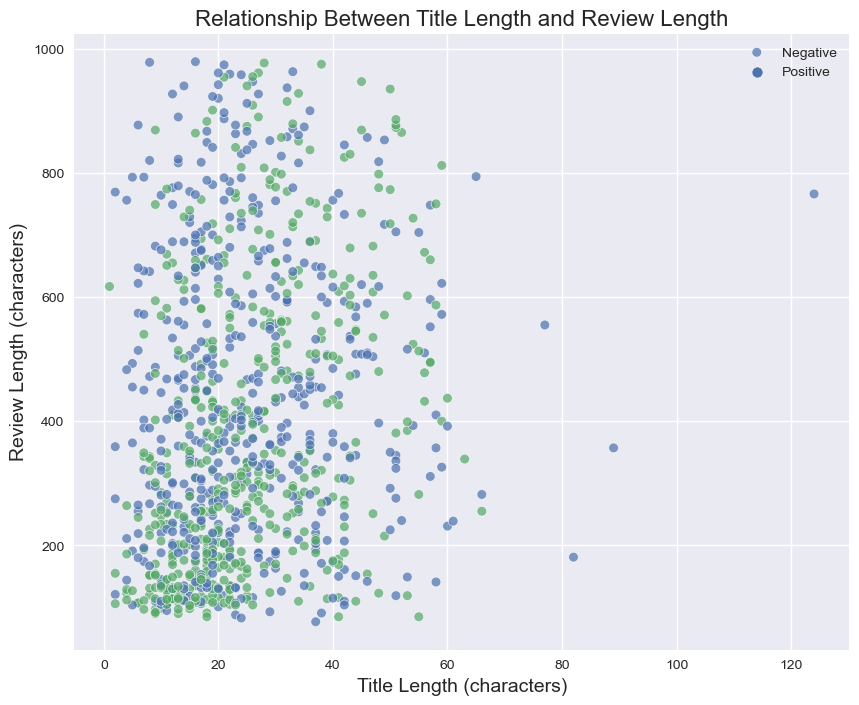

In [25]:
# Calculate correlation between title length and review length
title_review_corr = df[['title_length', 'review_length']].corr()
print("Correlation between title length and review length:")
print(title_review_corr)

# Visualize the relationship
plt.figure(figsize=(10, 8))
sns.scatterplot(x='title_length', y='review_length', hue='sentiment', data=df, alpha=0.7)
plt.title('Relationship Between Title Length and Review Length', fontsize=16)
plt.xlabel('Title Length (characters)', fontsize=14)
plt.ylabel('Review Length (characters)', fontsize=14)
plt.legend(['Negative', 'Positive'])
plt.show()

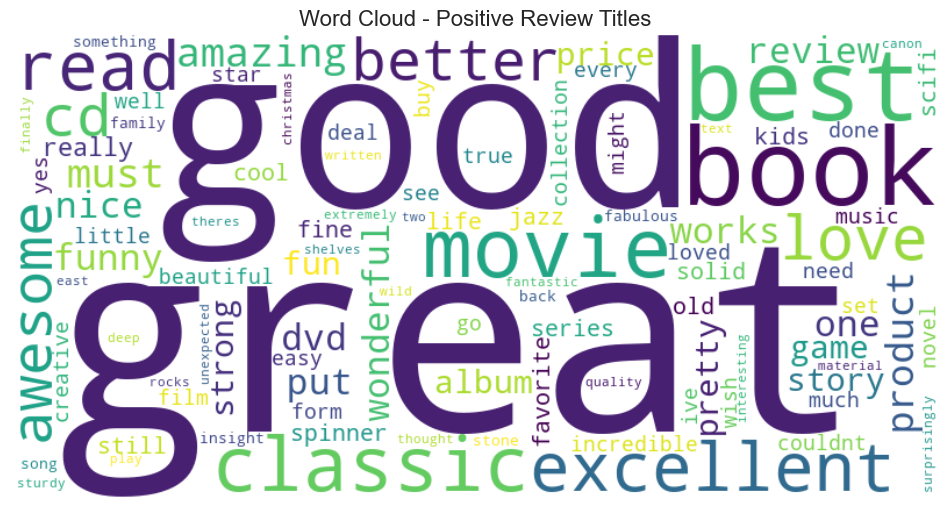

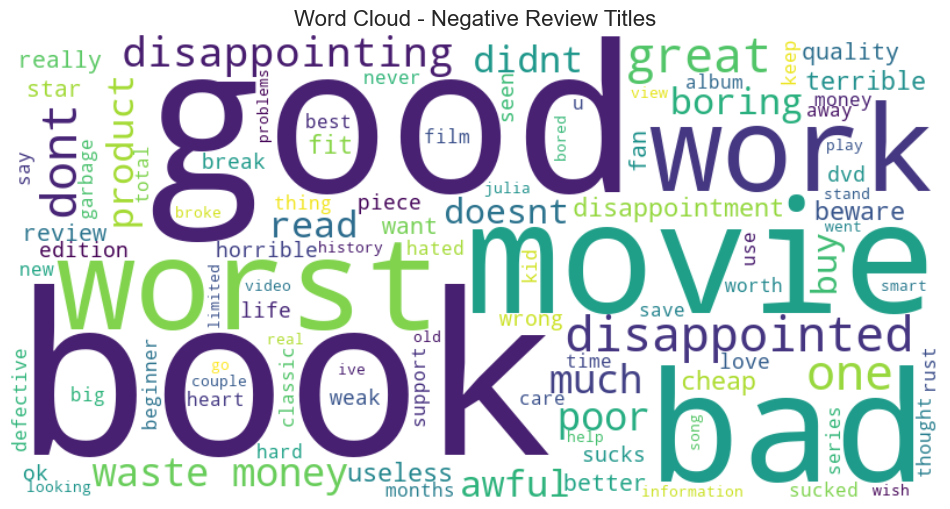

In [26]:
# Word clouds for titles by sentiment
positive_titles = df[df['sentiment'] == 1]['title']
negative_titles = df[df['sentiment'] == 0]['title']

generate_wordcloud(positive_titles, 'Word Cloud - Positive Review Titles')
generate_wordcloud(negative_titles, 'Word Cloud - Negative Review Titles')

## 8. Correlation Analysis

Let's examine the correlations between all our features and sentiment.

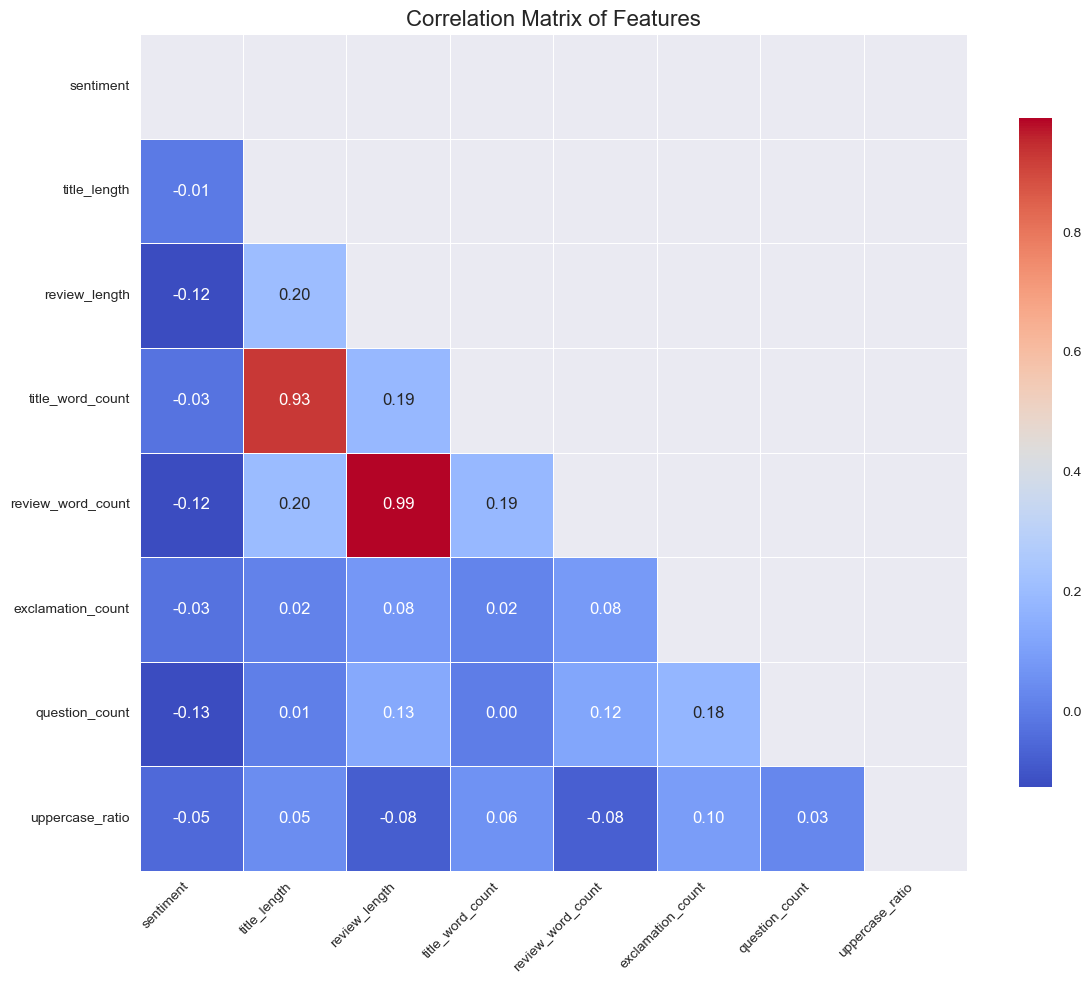

In [27]:
# Calculate correlations between numeric features
numeric_features = [
    'sentiment', 'title_length', 'review_length', 'title_word_count', 
    'review_word_count', 'exclamation_count', 'question_count', 'uppercase_ratio'
]

correlation_matrix = df[numeric_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Summary of Findings

Based on our exploratory data analysis, here are the key findings:

1. **Dataset Balance**: Our dataset contains a balanced distribution of positive and negative reviews.

2. **Text Length**: There appears to be a difference in text length between positive and negative reviews. In the chart for Review Lengths by Sentiment, we can see that theres a substantial peak at the sub 200 length section for negative reviews compared to positive reviews, suggesting customers may provide more brief explanations when expressing dissatisfaction.

3. **Common Words**: The most frequent words in positive reviews include "book", "one", "great", "movie", "good", "like", and "read", while negative reviews frequently contain similar words like "book", "one", "like", "would", "movie", "good", and "read". This interesting overlap suggests the dataset likely contains many book and movie reviews, with the sentiment often conveyed more through context and phrasing than specific positive or negative indicator words.

4. **Bigrams**: The most common phrase patterns in positive reviews include: "one best", "read book", "highly recommend", "year old", "would recommend", and "great cd". These patterns suggest strong recommendations, positive experiences, and frequently refer to gifts or suitable items for certain age groups. In negative reviews, the top bigrams are: "even though", "waste money", "much better", "thought would", "read book", "would recommend", and "could get". These phrases tend to convey disappointment, comparisons, and unmet expectations.

5. **Text Features**: 
- Exclamation marks: Positive reviews tend to contain more exclamation marks on average than negative ones. This suggests that positive sentiment may be expressed with more enthusiasm or excitement, whereas negative reviews are generally more reserved in punctuation.

- Question marks: Both sentiments rarely use question marks, but there is a slightly higher count in negative reviews. This could indicate that negative reviewers are more likely to express confusion, disappointment, or rhetorical questions.

- Uppercase ratio: There is no strong difference between positive and negative reviews in terms of the ratio of uppercase letters. However, both groups contain a few outliers with high uppercase usage, potentially reflecting emotional emphasis (e.g., shouting or emphasis like “DO NOT BUY”).

6. **Title-Review Relationship**: There is a weak positive correlation (correlation coefficient ≈ 0.205) between title length and review length. This suggests that, on average, longer titles tend to accompany longer reviews, but the relationship is not particularly strong. The scatterplot confirms this, showing a wide spread of review lengths across all title lengths. Additionally, both positive and negative reviews are distributed similarly, indicating that title length is not a strong differentiator of sentiment or review depth.

7. **Correlation Analysis**: Among the features analyzed, review length and review word count show the strongest (negative) correlations with sentiment, both around –0.12, suggesting that longer reviews are slightly more likely to be negative. Interestingly, question mark count also has a weak negative correlation (–0.13) with sentiment, reinforcing earlier observations that questions may signal dissatisfaction or confusion. Other features like exclamation count, uppercase ratio, and title characteristics have only very weak correlations (mostly between –0.05 and –0.01), indicating they may not individually carry strong predictive power but could still contribute when used in combination with other features during modeling.
